In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import json
from time import strftime, gmtime, sleep

import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.jumpstart.filters import And, Or
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
import boto3

from hydra import initialize, compose, core
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import tqdm

import IPython
from ipywidgets import Dropdown

sys.path.append(os.path.dirname(os.getcwd()))
from src import custom_utils

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='built_in_notebook')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)
# Group configs
built_in_config = config['built_in']

## S3

In [3]:
s3 = boto3.client('s3')

train_s3_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train_data'

## SageMaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sagemaker_session

sm_boto3 = boto3.client('sagemaker')
role = sagemaker.get_execution_role()

## List of Pretrained Models

In [ ]:
# Model version is a wildcard
model_id, model_version = 'tensorflow-od1-ssd-resnet50-v1-fpn-640x640-coco17-tpu-8', '*'

# Note that 'od1' models can be fine-tuned but 'od' models only support inference
filter_value = Or(
    And('task == od1', 'framework == tensorflow'), And('task == od', 'framework == tensorflow')
)

tensorflow_od_models = list_jumpstart_models(filter=filter_value)
dropdown = Dropdown(
    options=tensorflow_od_models,
    value=model_id,
    description='SageMaker Built-In TensorFlow Object Detection Models:',
    style={'description_width': 'initial'},
    layout={'width': 'max-content'},
)
display(IPython.display.Markdown('Select a SageMaker pre-trained model from the dropdown below'))
display(dropdown)

## Fine-Tuning

In [6]:
model_id, model_version = dropdown.value, '*'

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=model_id,
    model_version=model_version,
    image_scope='training',
    instance_type=built_in_config['instance_type']
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope='training'
)

# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope='training'
)

### Hyperparameter Tuning

In [7]:
# Default algorithm hyperparameters
params = hyperparameters.retrieve_default(model_id=model_id, model_version=model_version)

params

{'batch_size': '16',
 'reinitialize_top_layer': 'Auto',
 'train_only_top_layer': 'True',
 'optimizer': 'adam',
 'learning_rate': '0.002',
 'beta_1': '0.9',
 'beta_2': '0.999',
 'momentum': '0.9',
 'epsilon': '1e-07',
 'rho': '0.95',
 'initial_accumulator_value': '0.1',
 'early_stopping': 'True',
 'early_stopping_patience': '5',
 'early_stopping_min_delta': '0.0',
 'epochs': '20'}

In [8]:
# Tuning hyperparameters
built_in_search_space = {
    'learning_rate': ContinuousParameter(1e-6, 0.5, scaling_type='Logarithmic'),
    'batch_size': CategoricalParameter([16, 32, 64]),
    'optimizer': CategoricalParameter(['sgd', 'adam', 'rmsprop']),
    # For sgd
    'momentum': ContinuousParameter(0.0, 0.999),
    # For adam and rmsprop
    'beta_1': ContinuousParameter(0.6, 0.999),
    'beta_2': ContinuousParameter(0.8, 0.999),
    'epsilon': ContinuousParameter(1e-9, 1e-1, scaling_type='Logarithmic'),
    'rho': ContinuousParameter(0.7, 0.999),
    'epochs': IntegerParameter(15, 30),
    'early_stopping_patience': IntegerParameter(3, 7)
}

In [9]:
# Metric to monitor and optimize
metrics_definitions = {
    'metrics': [{'Name': 'validation:localization_loss', 'Regex': 'Val_localization=([0-9\\.]+)'}],
    'type': 'Minimize'
}

In [11]:
built_in_estimator = Estimator(
    # SageMaker
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters=params,
    volume_size=config['volume_size'],
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    output_path=config['output_path'],
    code_location=config['code_location'],
    # Spot training
    max_retry_attempts=config['max_retry_attempts'],
    use_spot_instances=config['use_spot_instances'],
    max_wait=config['max_run'],
    max_run=config['max_run'],
    checkpoint_s3_uri=config['checkpoint_s3_uri'],
    # Group config
    entry_point=built_in_config['transfer_entry_point'],
    instance_count=built_in_config['instance_count'],
    instance_type=built_in_config['instance_type'],
    base_job_name=built_in_config['base_job_name']
)

# Tuner
built_in_tuner = HyperparameterTuner(
    estimator=built_in_estimator,
    objective_metric_name=metrics_definitions['metrics'][0]['Name'],
    hyperparameter_ranges=built_in_search_space,
    metric_definitions=metrics_definitions['metrics'],
    strategy='Bayesian',
    objective_type=metrics_definitions['type'],
    max_jobs=1,
    max_parallel_jobs=1,
    base_tuning_job_name=built_in_config['base_tuning_job_name']
)

In [12]:
built_in_tuner.fit(inputs=train_s3_path, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Hyperparameter results:

In [10]:
built_in_hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(built_in_tuner.latest_tuning_job.name)

built_in_hpo_results = built_in_hpo_analytics.dataframe()

built_in_hpo_results.sort_values('FinalObjectiveValue', ascending=False).head(10)

,batch_size,beta_1,beta_2,early_stopping_patience,epochs,epsilon,learning_rate,momentum,optimizer,rho,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,64.0,0.992008,0.993307,4.0,24.0,0.014222,0.000326,0.880701,rmsprop,0.969225,od-built-in-hpo-230721-1807-001-15e87959,Completed,0.983,2023-07-21 18:08:58+00:00,2023-07-21 20:01:52+00:00,6774.0


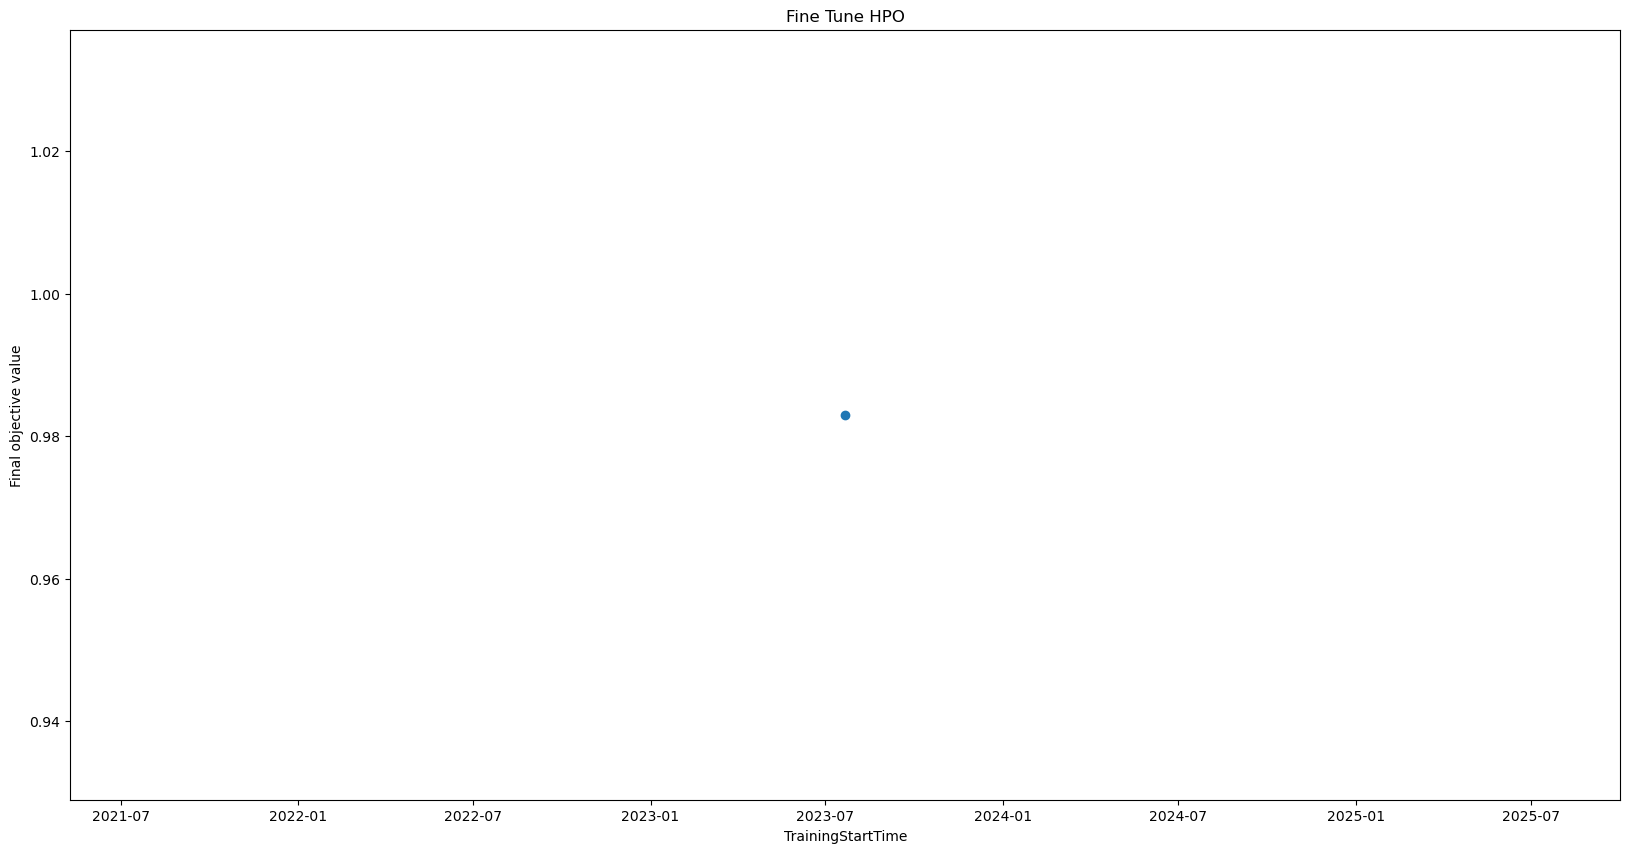

In [11]:
plt.figure(figsize=(20, 10))
# Remove missing values in TrainingStartTime
built_in_hpo_results = built_in_hpo_results[built_in_hpo_results['TrainingStartTime'].notna()]
# Sort by TrainingStartTime
built_in_hpo_results.sort_values('TrainingStartTime', inplace=True)
plt.scatter(built_in_hpo_results['TrainingStartTime'], built_in_hpo_results['FinalObjectiveValue'])
plt.plot(built_in_hpo_results['TrainingStartTime'], built_in_hpo_results['FinalObjectiveValue'].rolling(2).mean())
plt.xlabel('TrainingStartTime')
plt.ylabel('Final objective value')
plt.title('Fine Tune HPO')
plt.show();

## Inference

In [12]:
# Image uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope='inference',
    model_id=model_id,
    model_version=model_version,
    instance_type=built_in_config['instance_type']
)

# Script uri
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope='inference'
)

# Best model name
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=built_in_tuner.latest_tuning_job.name
)['BestTrainingJob']['TrainingJobName']

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(
    TrainingJobName=best_model_name
)['ModelArtifacts']['S3ModelArtifacts']

print(f'Best model artifacts persisted at {best_model_s3_path}')

Best model artifacts persisted at s3://yang-ml-homepartners/object-detection/models/od-built-in-hpo-230721-1807-001-15e87959/output/model.tar.gz


Deploy best model from model artifacts:

In [13]:
best_model = Model(
    model_data=best_model_s3_path,
    role=role,
    image_uri=deploy_image_uri,
    name=built_in_config['model_name'],
    sagemaker_session=sagemaker_session,
    source_dir=deploy_source_uri,
    entry_point=built_in_config['inference_entry_point']
)

best_model.deploy(
    initial_instance_count=built_in_config['instance_count'],
    instance_type=built_in_config['instance_type'],
    endpoint_name=built_in_config['endpoint_name'] + '-' + strftime('%H-%M-%S', gmtime())
)

predictor = Predictor(
    endpoint_name=best_model.endpoint_name,
    sagemaker_session=sagemaker_session
)

------------!

List of paths to test images:

In [14]:
images = [os.path.join(config['test_images'], file) for file in os.listdir(config['test_images'])]

Predictions:

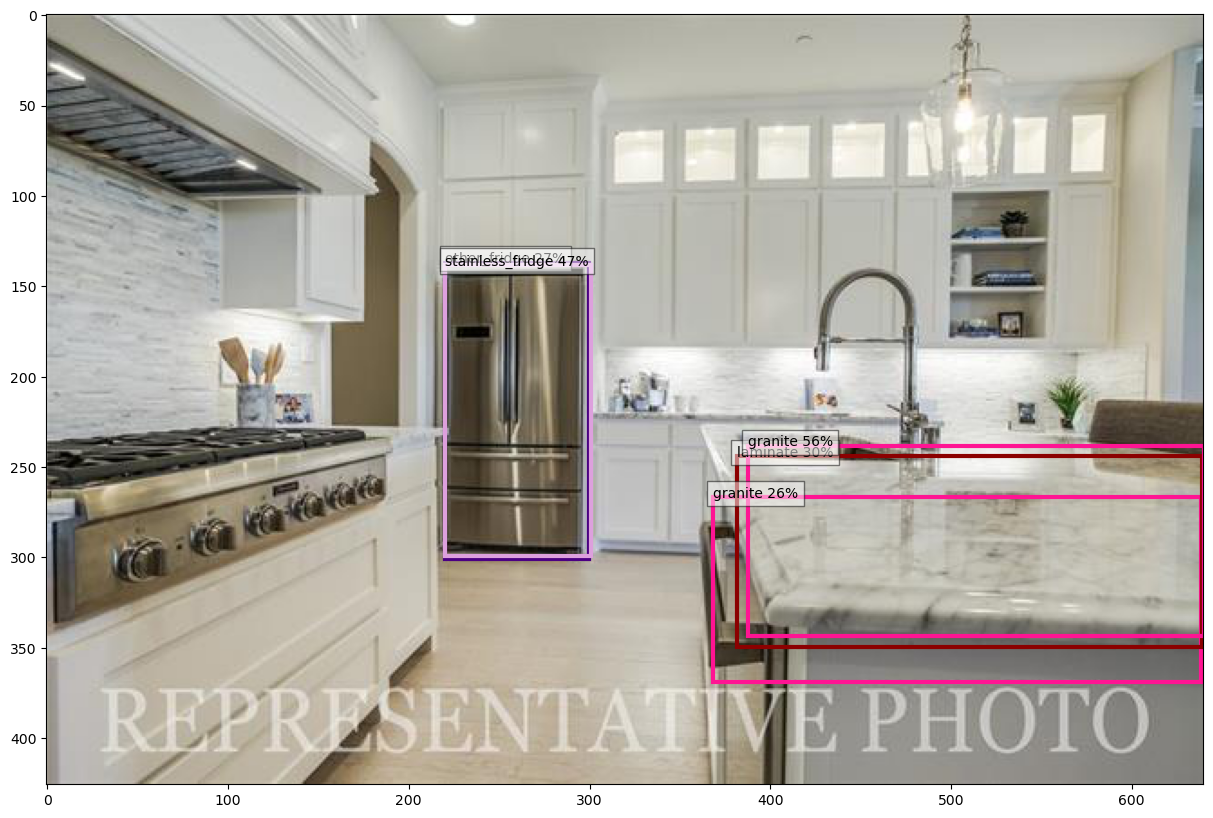

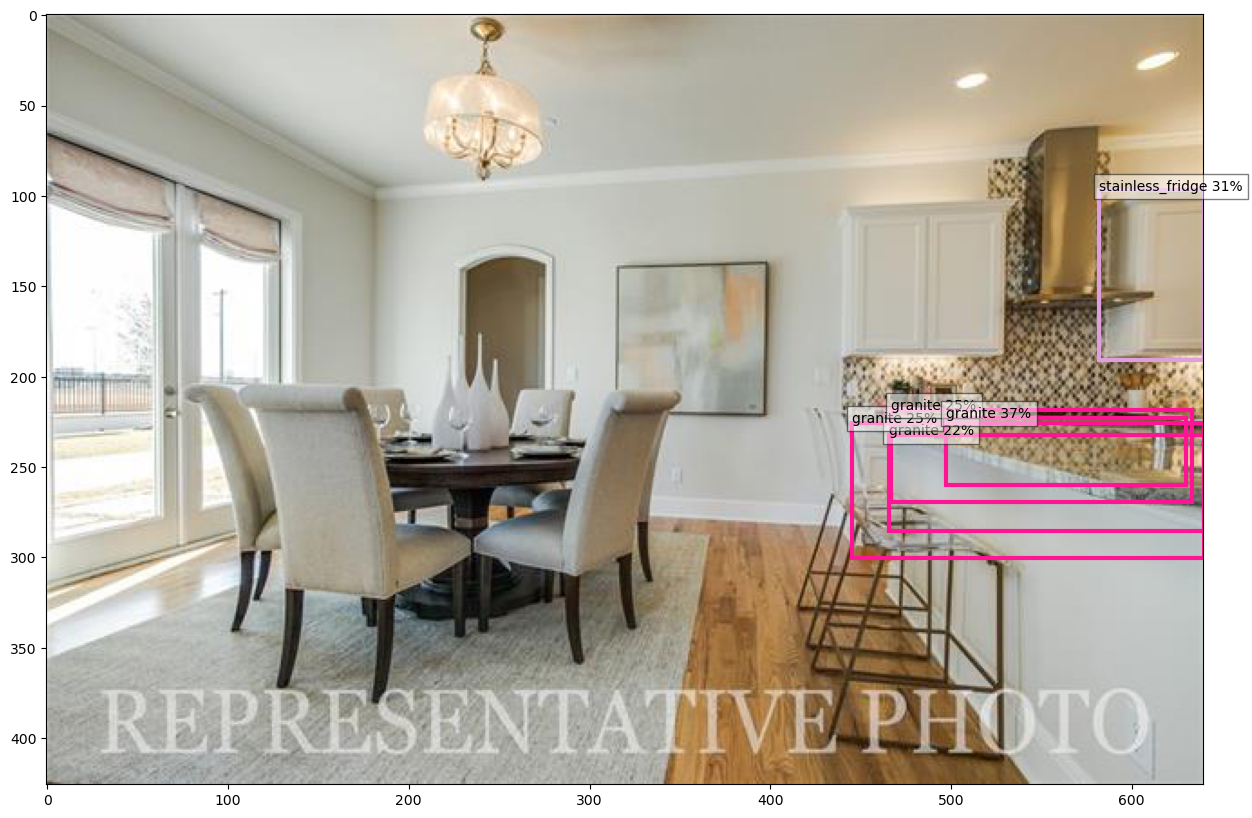

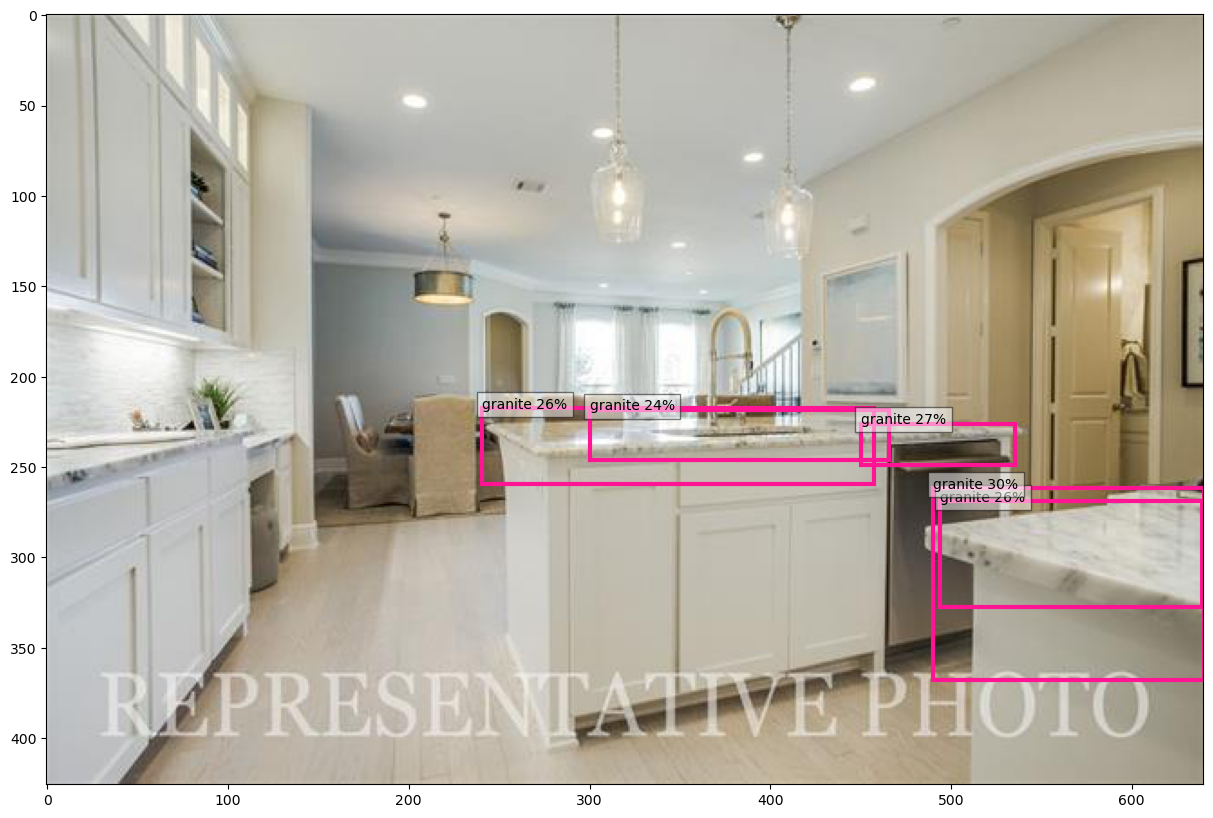

In [15]:
# Instantaite the inference handler
inference_handler = custom_utils.InferenceHandler(
    model_predictor=predictor,
    # Reverse the mapping to label_int: label_str 
    class_label_map={str(v): k for k, v in config['class_label_map'].items()}
)

for image in images:

    # Obtain the predictions
    normalized_boxes, class_names, scores = inference_handler.predict(image_file_path=image, num_boxes=5)

    # Plot the prediction
    inference_handler.plot_predictions(
        image_file_path=image,
        normalized_boxes=normalized_boxes,
        class_names=class_names,
        confidences=scores,
        figsize=(20, 10)
    )

    # Wait before making another invocation
    sleep(3)

## Clean-up

In [16]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': '80cf0197-b248-4e7d-9869-3ae84149aa9e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '80cf0197-b248-4e7d-9869-3ae84149aa9e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 21 Jul 2023 20:48:41 GMT'},
  'RetryAttempts': 0}}

In [17]:
sm_boto3.close()